<a href="https://colab.research.google.com/github/polina-minaeva/text-tonality-classification/blob/main/%D0%A2%D0%B5%D0%BC%D0%B0%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%B5_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%B8_%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D1%8F_%D0%BE%D1%82%D0%B7%D1%8B%D0%B2%D0%BE%D0%B2_%D0%BD%D0%B0_%D0%B1%D0%B0%D0%BD%D0%BA%D0%B8_1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Доступны данные об отзывах клиентов на российские банки с сайта banki.ru – banki_responses.json.bz2. Проведем их анализ, выведем главные темы отзывов и классифицируем отзывы по тональности, используя n-граммы и скрытые темы.




# Загрузка библиотек

Получение и представление данных

In [3]:
import json

import bz2
import regex
from tqdm import tqdm
from scipy import sparse

In [4]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Для работы с текстами и словами

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [18]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [19]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [21]:
from nltk.corpus import stopwords
from nltk import pos_tag, word_tokenize

In [27]:
from collections import Counter

In [31]:
pip install pymorphy2

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 97.7 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13704 sha256=cf8adf0551a15b4263bcfbcdb07498a0ceeeaa14cc06d1501ff89d58fb5ae07b
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [32]:
import pymorphy2

morph = pymorphy2.MorphAnalyzer()

In [35]:
from nltk.stem import WordNetLemmatizer
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [38]:
from pymystem3 import Mystem
m = Mystem()

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


In [57]:
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim import similarities
from sklearn.feature_extraction.text import CountVectorizer
from gensim import matutils, models
import gensim
from gensim.models import lsimodel

In [40]:
import re

In [48]:
import seaborn as sns

Для моделей

In [67]:
from sklearn.metrics import *
from sklearn.model_selection import train_test_split

In [68]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [69]:
from sklearn.metrics import classification_report

In [70]:
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_extraction.text import TfidfTransformer

# Загрузка данных

In [5]:
'''Подключаемся к гугл диску'''

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
'''Получим файл banki_responses.json.bz2, который содержит данные об отзывах клиентов на банки'''

filet = 'drive/MyDrive/Colab Notebooks/banki_responses.json.bz2'
filet

'drive/MyDrive/Colab Notebooks/banki_responses.json.bz2'

In [7]:
responses = []
with bz2.BZ2File(filet, 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [01:14, 2699.65it/s]


In [11]:
'''Как выглядят данные: информация о городе, о банке, сам отзыв и оценка'''

responses[50]

{'city': 'г. Новочеркасск',
 'rating_not_checked': False,
 'title': 'отзыв',
 'num_comments': 1,
 'bank_license': 'лицензия № 1792',
 'author': '07092008',
 'bank_name': 'Русфинанс Банк',
 'datetime': '2015-06-08 11:18:41',
 'text': 'Добрый день, хочу написать свой отзыв о работе банка. Мне пришлось столкнуться с неприятностью. Выплатив кредит полностью, я явилась в офис банка в г. Ростов-на- Дону, ул.Театральная 60., получила на руки справку о погашении задолжености, следующим шагом моим было изъявление желания о закрытии счета, но оказалось, что на счете имеется переплата в 90 копеек,я написала заявление о зачислении денег на счет банка, для того чтобы наконец то получить справку о закрытии моего счета, это было 22 мая 2015 года, 08.06.2015г. мной был сделан звонок в банк с целью выяснения, почему так долго списывается сумма в 90 копеек с моего счета и когда же наконец я его закрою, на что был получен ответ, что 90 копеек там еще до сих пор висят,  сколько можно ждать, простой формал

In [10]:
'''Переносим данные в формат датафрейма для удобства'''

df = pd.DataFrame(responses)
df.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN


# Часть 1. Анализ текстов

##Количество отзывов по городам

In [12]:
df['city'].value_counts()

,count
city,
г. Москва,55354
г. Санкт-Петербург,14342
г. Екатеринбург,2337
г. Новосибирск,2300
г. Нижний Новгород,1976
...,...
г. г.Калуга,1
г. ВЕЛИКИЕ ЛУКИ,1
г. всеволожск,1


##Количество отзывов по банкам

In [13]:
df['bank_name'].value_counts()

,count
bank_name,
Сбербанк России,26327
Альфа-Банк,10224
ВТБ 24,8185
Русский Стандарт,7943
Хоум Кредит Банк,7549
...,...
Сиббизнесбанк,1
Донбанк,1
Потенциал,1


##Гистограмма длин отзывов в словах

In [14]:
hist_words = []

for client in responses:
  resp = re.findall('[a-zа-яё]+', client['text'], flags=re.IGNORECASE)
  hist_words.append(len(resp))

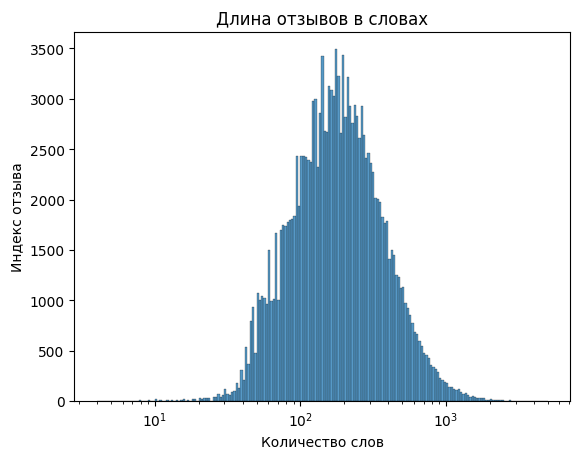

In [15]:
sns.histplot(data=hist_words, log_scale=True).set(title='Длина отзывов в словах', xlabel='Количество слов', ylabel='Индекс отзыва')
plt.show()

##Гистограмма длин отзывов в символах

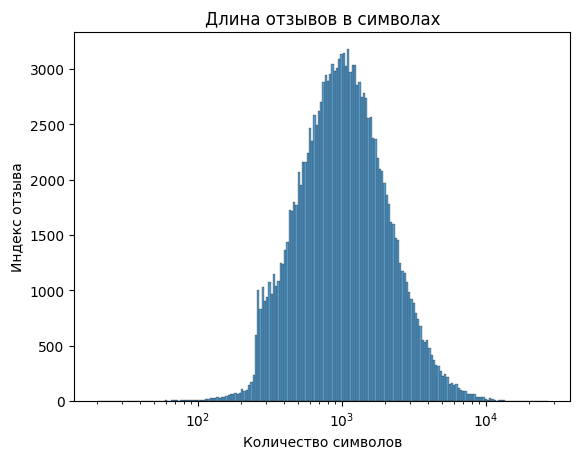

In [16]:
hist_sym = []

for person in responses:
    person_text = person['text'].replace(' ', '')
    hist_sym.append(len(person_text))

sns.histplot(data=hist_sym, log_scale=True).set(title='Длина отзывов в символах', xlabel='Количество символов', ylabel='Индекс отзыва')
plt.show()

Для дальнейшей работы будем пользоваться лишь частью данных.

In [34]:
df['text'].count()

153499

In [25]:
texts = df['text'][:5000]

Вытащим из данных слова. Для этого: проводим токенизацию, приводит данные к нижнему регистру, убираем пунктуацию, убираем стоп-слова

In [22]:
all_text = ' '.join(texts)

tokens = word_tokenize(all_text)

In [23]:
words = [word.lower() for word in tokens if word.isalnum()]

tokens = [word for word in tokens if word.isalnum()]

In [24]:
stop_words = set(stopwords.words('russian'))
filtered_words = [word for word in words if word not in stop_words]

## 10 самых частых слов в отзывах

In [29]:
word_counts = Counter(tokens)
word_counts.most_common(10)

[('в', 32525),
 ('и', 28132),
 ('не', 23931),
 ('на', 18364),
 ('что', 16992),
 ('с', 12838),
 ('я', 12659),
 ('по', 10415),
 ('мне', 8605),
 ('банка', 7170)]

##10 самых частых слов в отзывах (не учитывая стоп-слова)

In [30]:
cl_word_counts = Counter(filtered_words)
cl_word_counts.most_common(10)

[('банка', 8243),
 ('банк', 6303),
 ('это', 5057),
 ('деньги', 3422),
 ('карты', 3046),
 ('карту', 2912),
 ('день', 2393),
 ('кредит', 2352),
 ('заявление', 1916),
 ('банке', 1863)]

##10 самых частых лемм в отзывах

In [33]:
try:
    lemmas = [morph.parse(w)[0].normal_form for w in all_text.split(' ')]
    counter = Counter(lemmas)
    print(counter.most_common(10))
except:
    print("Ошибка при лемматизации текста.")

[('в', 36363), ('я', 30521), ('и', 29293), ('не', 24451), ('на', 19805), ('что', 17482), ('с', 15083), ('банк', 12574), ('по', 10829), ('быть', 10716)]


##10 самых частых существительных в отзывах

In [37]:
try:
    lemmas = [morph.parse(w)[0].normal_form for w in all_text.split(' ')]
    nouns = [lemma for lemma in lemmas if morph.parse(lemma)[0].tag.POS == 'NOUN']

    counter = Counter(nouns)
    print(counter.most_common(10))
except:
    print("Ошибка при анализе текста.")

[('банк', 12574), ('карта', 6370), ('сотрудник', 3686), ('деньга', 3261), ('мочь', 3033), ('кредит', 2933), ('сумма', 2654), ('отделение', 2650), ('день', 2587), ('счёт', 2532)]


In [43]:
counter['сотрудник'] < counter['клиент']

False

In [41]:
counter['мошенничество']

39

In [42]:
counter['доверие']

68

##Кривая Ципфа

In [44]:
def zipf_curve(text): #функция для будущего ответа
    word_freq = nltk.FreqDist(text)
    sorted_freq = sorted(word_freq.values(), reverse=True)
    ranks = np.arange(1, len(sorted_freq) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(ranks, sorted_freq, marker='o', linestyle='-')
    plt.title('Кривая Ципфа')
    plt.xlabel('Ранг слова')
    plt.ylabel('Частота слова')
    plt.show()

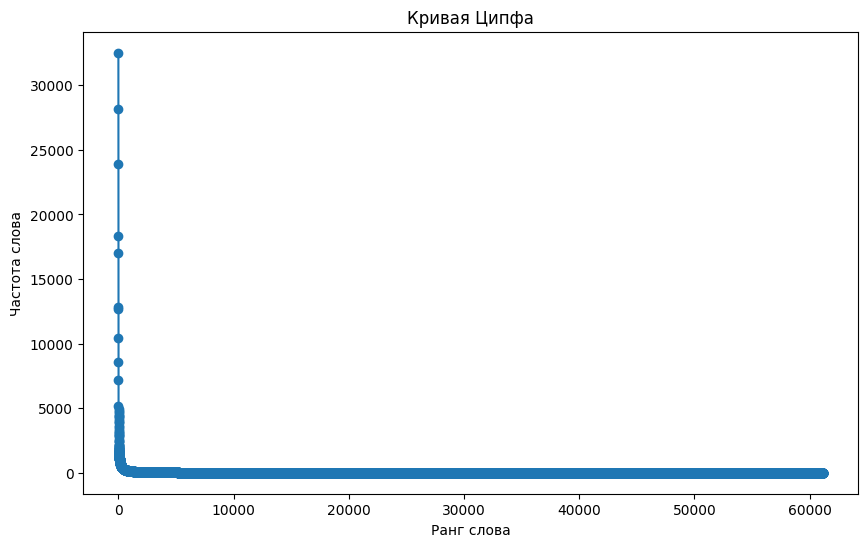

In [45]:
zipf_curve(tokens) #применение функции

## Кривая Хипса

In [46]:
def heaps_curve(text): #функция для будущего ответа
    corpus = []
    vocab_sizes = []
    words_seen = set()
    for word in text:
        words_seen.add(word)
        corpus.append(len(words_seen))
        vocab_sizes.append(len(words_seen))
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(corpus)), vocab_sizes, marker='o', linestyle='-')
    plt.title('Кривая Хипса')
    plt.xlabel('Размер корпуса')
    plt.ylabel('Размер словаря')
    plt.show()

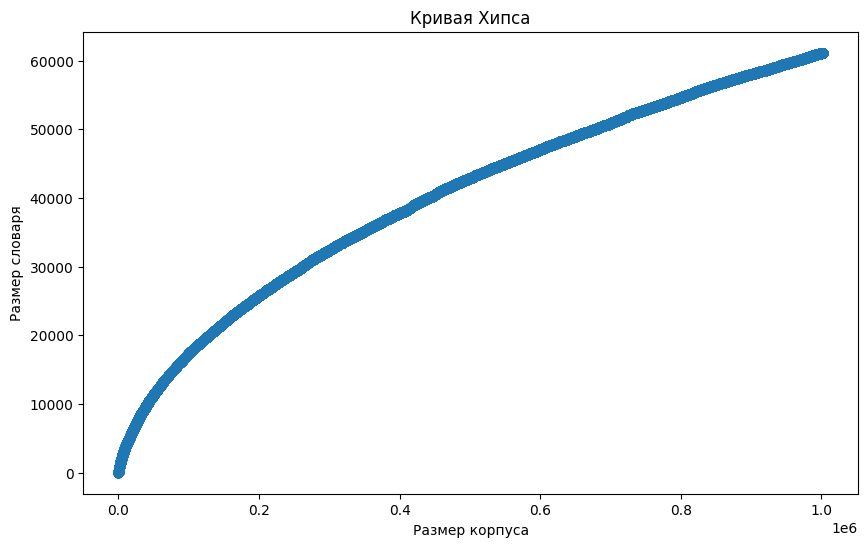

In [47]:
heaps_curve(tokens) #применение функции

#Часть 2. Тематическое моделирование

Для построения модели обработаем данные и получим слова из отзывов

In [49]:
ru_words = re.compile("[А-Яа-я]+")

m = Mystem()

def words_only(text):
    return " ".join(ru_words.findall(text))

def lemmatize(text, mystem=m):
    try:
        return " ".join([m.lemmatize(w)[0] for w in text.split(' ')])
    except:
        return " "

def remove_stopwords(text, mystopwords = stop_words):
    try:
        return " ".join([token for token in text.split(' ') if not token in mystopwords])
    except:
        return ""

def preprocess(text): #функция для будущего ответа
    return remove_stopwords(lemmatize(words_only(text.lower())))

In [50]:
limitedDf = df.iloc[:5000].text #выбранные данные из датафрейма

In [51]:
limitedDf = limitedDf.apply(preprocess) #применение функции

CPU times: user 37.7 s, sys: 10.3 s, total: 47.9 s
Wall time: 2min 28s


In [52]:
'''Создадим словарь и корпус из слов'''

texts = [text.split() for text in limitedDf]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [53]:
'''Вносим корпус в модель и получаем Tfidf-представление слов'''

tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [54]:
index = similarities.MatrixSimilarity(corpus_tfidf)
sims = index[corpus_tfidf]

In [58]:
'''Модель LsiModel для выделения тем из текстов'''

lsi = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=30)

In [59]:
lsi.show_topics(5) #отображение важных слов для каждой темы

[(0,
  '0.189*"карта" + 0.136*"кредит" + 0.115*"деньги" + 0.110*"вклад" + 0.102*"счет" + 0.100*"заявление" + 0.099*"отделение" + 0.098*"сумма" + 0.096*"сотрудник" + 0.095*"сбербанк"'),
 (1,
  '-0.274*"вклад" + 0.253*"звонок" + 0.225*"номер" + -0.210*"карта" + 0.191*"ваш" + 0.181*"кредит" + 0.151*"телефон" + 0.128*"звонить" + 0.127*"персональный" + -0.124*"банкомат"'),
 (2,
  '-0.652*"вклад" + 0.205*"карта" + -0.203*"ставка" + -0.161*"договор" + 0.161*"банкомат" + 0.151*"сбербанк" + -0.147*"условие" + -0.131*"пополнение" + -0.130*"открывать" + -0.114*"процент"'),
 (3,
  '-0.373*"страховка" + -0.303*"кредит" + -0.295*"страхование" + 0.214*"вклад" + 0.197*"номер" + -0.153*"договор" + -0.147*"страховой" + 0.140*"звонок" + -0.127*"погашение" + 0.121*"карта"'),
 (4,
  '0.197*"средство" + 0.186*"платеж" + -0.177*"заявка" + 0.167*"денежный" + 0.167*"сумма" + 0.144*"счет" + 0.134*"договор" + -0.132*"отделение" + 0.132*"руб" + 0.129*"задолженность"')]

Анализируя результаты модели, видим, что:

1.   Нулевая тема связана со Сбербанком, с кредитами и вкладами.
2.   Первая тема связана со звонками клиенту и кредитами.
3.   Вторая тема связана с банкоматами и банковской картой.
4.   Третья тема связана со звонками клиенту и вкладами.
5.   Четвертая тема связана с банковским счетом, договором, платежами и задолженностями.

In [60]:
topics = lsi.show_topics(num_topics=5)

Посмотрим, как в темах отображаются некоторые банки

In [61]:
banks = ['Сбербанк России', 'ВТБ 24', 'Русский Стандарт', 'Альфа-Банк']

In [62]:
for topic_id, topic in topics:
    terms = [term.split('*')[1].strip() for term in topic.split('+')]
    for bank in banks:
        if any(bank.lower() in term.lower() for term in terms):
            print(f"Тема {topic_id} содержит упоминание банка '{bank}'")
            print("Термины темы:", terms)
            print("\n")

Тема 0 содержит упоминание банка 'Сбербанк России'
Термины темы: ['"карта"', '"кредит"', '"деньги"', '"вклад"', '"счет"', '"заявление"', '"отделение"', '"сумма"', '"сотрудник"', '"сбербанк"']


Тема 0 содержит упоминание банка 'ВТБ 24'
Термины темы: ['"карта"', '"кредит"', '"деньги"', '"вклад"', '"счет"', '"заявление"', '"отделение"', '"сумма"', '"сотрудник"', '"сбербанк"']


Тема 0 содержит упоминание банка 'Русский Стандарт'
Термины темы: ['"карта"', '"кредит"', '"деньги"', '"вклад"', '"счет"', '"заявление"', '"отделение"', '"сумма"', '"сотрудник"', '"сбербанк"']


Тема 0 содержит упоминание банка 'Альфа-Банк'
Термины темы: ['"карта"', '"кредит"', '"деньги"', '"вклад"', '"счет"', '"заявление"', '"отделение"', '"сумма"', '"сотрудник"', '"сбербанк"']


Тема 1 содержит упоминание банка 'Сбербанк России'
Термины темы: ['"вклад"', '"звонок"', '"номер"', '"карта"', '"ваш"', '"кредит"', '"телефон"', '"звонить"', '"персональный"', '"банкомат"']


Тема 1 содержит упоминание банка 'ВТБ 24'
Тер

<ipython-input-63-f26cb20da866>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_topic, x='Weight', y='Term', palette='viridis')


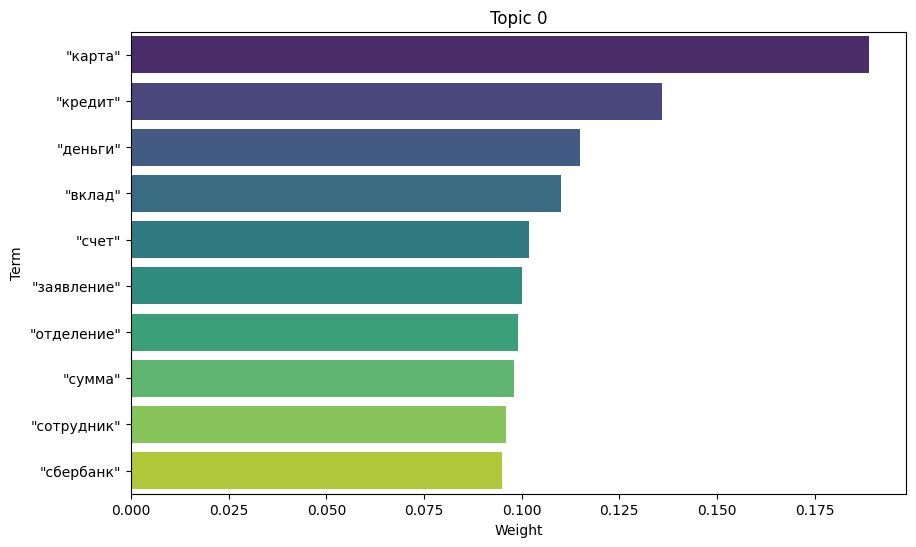

<ipython-input-63-f26cb20da866>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_topic, x='Weight', y='Term', palette='viridis')


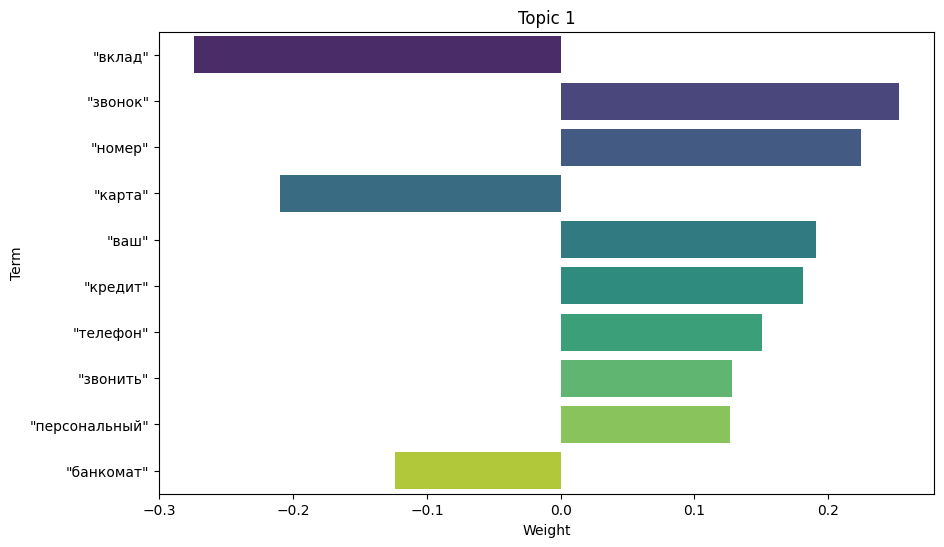

<ipython-input-63-f26cb20da866>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_topic, x='Weight', y='Term', palette='viridis')


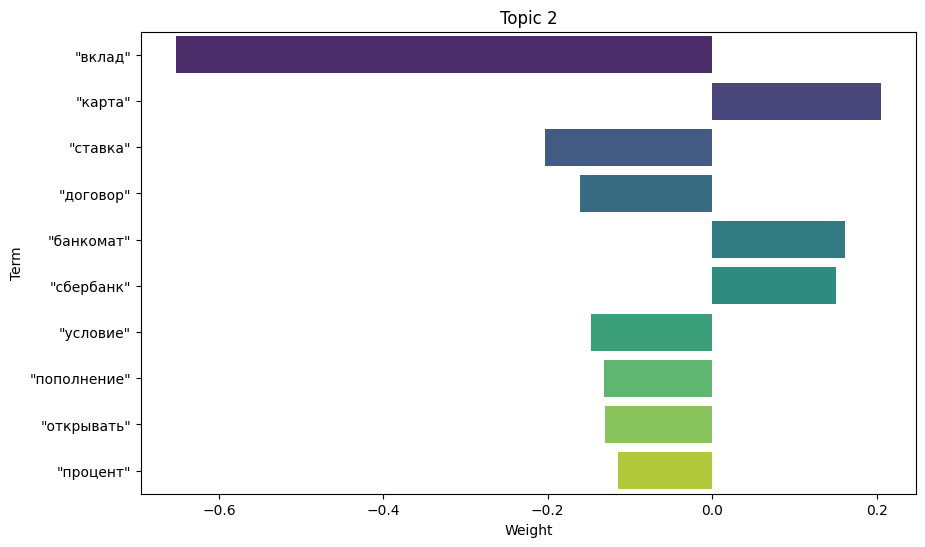

<ipython-input-63-f26cb20da866>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_topic, x='Weight', y='Term', palette='viridis')


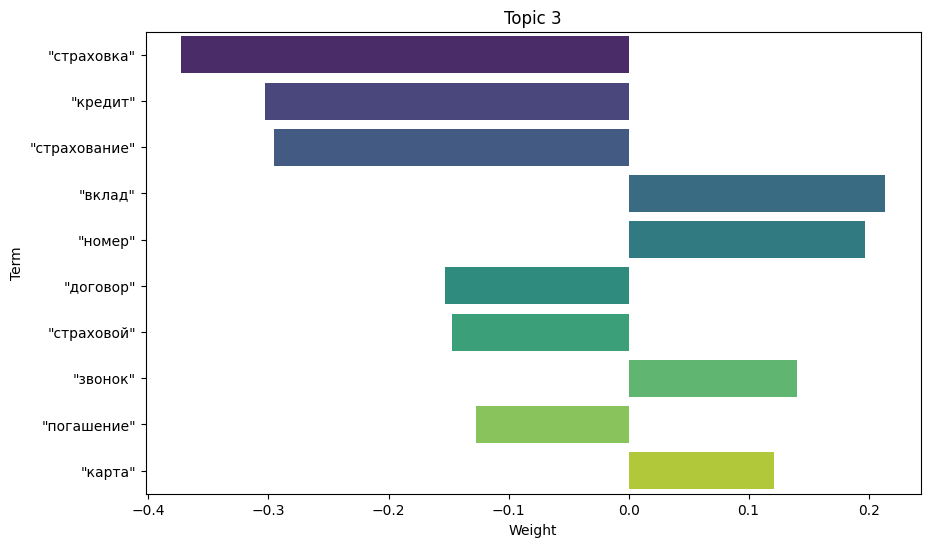

<ipython-input-63-f26cb20da866>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_topic, x='Weight', y='Term', palette='viridis')


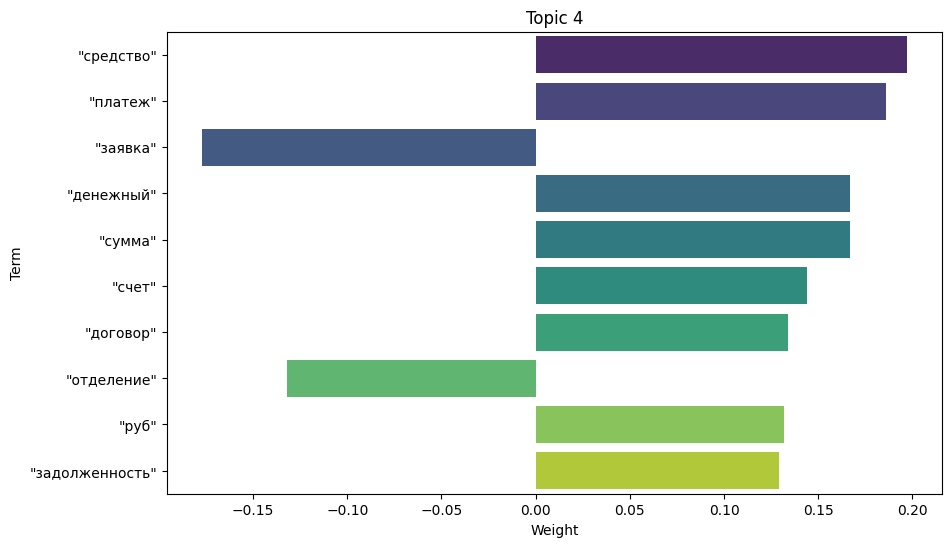

In [63]:
for topic_id, topic in topics:
    terms = [term.split('*')[1].strip() for term in topic.split('+')]
    weights = [float(term.split('*')[0]) for term in topic.split('+')]

    # Создание DataFrame для визуализации
    df_topic = pd.DataFrame({'Term': terms, 'Weight': weights})

    # Построение столбчатой диаграммы для текущей темы
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_topic, x='Weight', y='Term', palette='viridis')
    plt.title(f'Topic {topic_id}')
    plt.xlabel('Weight')
    plt.ylabel('Term')
    plt.show()

#Часть 3. Классификация отзывов по тональности

Будем классифицировать тексты с оценками 1 и 5

In [65]:
'''Выбор данных'''

neg_reviews = df[df['rating_grade'] == 1].sample(n=3000, random_state=42)
pos_reviews = df[df['rating_grade'] == 5].sample(n=3000, random_state=42)

sel_reviews = pd.concat([neg_reviews, pos_reviews])

In [71]:
'''Разделение данных на тренировочную и тестовую выборки'''

X_train, X_test, y_train, y_test = train_test_split(sel_reviews['text'], sel_reviews['rating_grade'], test_size=0.2, random_state=42)

##1) Классификация с помощью n-грам

Будем использовать классификатор MultinomialNB(). Построем несколько моделей с разными признаками. В качестве признаков попробуем использовать униграмы, биграмы и триграмы

In [75]:
classifier = MultinomialNB()

In [76]:
vectorizers = {
    "Униграмы": CountVectorizer(ngram_range=(1, 1)),
    "Биграмы": CountVectorizer(ngram_range=(1, 2)),
    "Триграмы": CountVectorizer(ngram_range=(1, 3))
}



for name, vectorizer in vectorizers.items():
    pipeline = Pipeline([
        ('vectorizer', vectorizer),
        ('classifier', classifier)
    ])

    pipeline.fit(X_train, y_train)
    train_score = pipeline.score(X_train, y_train)
    test_score = pipeline.score(X_test, y_test)

    print(f"Векторизация: {name}")
    print(f"Точность на обучающем множестве: {train_score:.3f}")
    print(f"Точность на тестовом множестве: {test_score:.3f}")
    print("-------------------------------------")

Векторизация: Униграмы
Точность на обучающем множестве: 0.971
Точность на тестовом множестве: 0.923
-------------------------------------
Векторизация: Биграмы
Точность на обучающем множестве: 0.998
Точность на тестовом множестве: 0.922
-------------------------------------
Векторизация: Триграмы
Точность на обучающем множестве: 1.000
Точность на тестовом множестве: 0.919
-------------------------------------


##2) Классификация с помощью скрытых тем

In [77]:
'''Классификация с помощью tfidf-преобразования и сингулярного разложения'''

tfidf_lsi_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('svd', TruncatedSVD(n_components=30)),
    ('clf', RandomForestClassifier())
])

In [78]:
'''Классификация с помощью LDA'''

lda_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('lda', LatentDirichletAllocation(n_components=30, random_state=42)),
    ('clf', RandomForestClassifier())
])

In [79]:
for name, pipeline in [("tf-idf + LSI", tfidf_lsi_pipeline), ("LDA", lda_pipeline)]:

    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"Метод: {name}")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"F1-score: {f1:.3f}")
    print(classification_report(y_test, y_pred))
    print("----------------------------------------")

Метод: tf-idf + LSI
Accuracy: 0.884
F1-score: 0.884
              precision    recall  f1-score   support

         1.0       0.86      0.92      0.89       613
         5.0       0.91      0.85      0.88       587

    accuracy                           0.88      1200
   macro avg       0.89      0.88      0.88      1200
weighted avg       0.89      0.88      0.88      1200

----------------------------------------
Метод: LDA
Accuracy: 0.844
F1-score: 0.844
              precision    recall  f1-score   support

         1.0       0.90      0.78      0.84       613
         5.0       0.80      0.91      0.85       587

    accuracy                           0.84      1200
   macro avg       0.85      0.85      0.84      1200
weighted avg       0.85      0.84      0.84      1200

----------------------------------------


Как итог, у классификации с помощью n-грам точность модели выше. Но и результаты классифкации с п мощью скрытых тем оказались достойными: выше 80.